# Problem 7.1


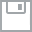
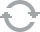
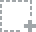
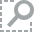
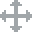
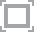
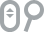
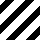
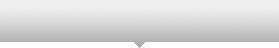
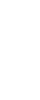
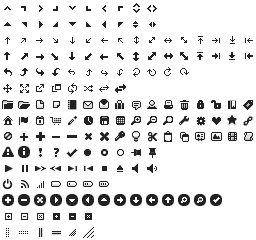
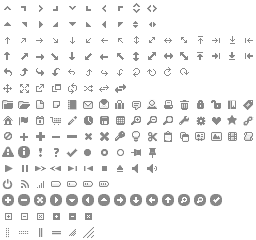
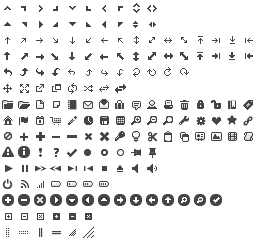
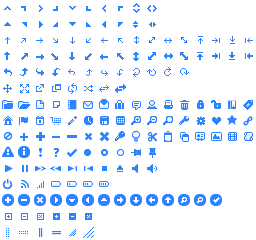
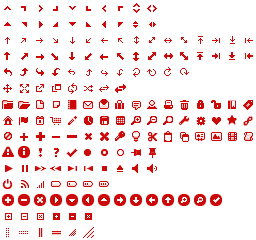
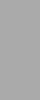
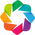
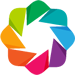

In [95]:
import glob
import os
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats as st

# BE/Bi 103 utilities
import sys
sys.path.insert(0, '/Users/Rusty/bebi103_utils')
import bebi103

# Image processing tools
import skimage
import skimage.io

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.io
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# The directory containing daytime data
data_dir = 'Cassiopea_Pulsation/day'

# Glob string for images
im_glob = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob)

In [3]:
# Read in the image using skimage
im = skimage.io.imread(im_list[0])

# Just slice the red channel
im = im[0,:,:]

with sns.axes_style('white'):
    skimage.io.imshow(im)

In [4]:
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)

def squish_rgb(fname):
    return skimage.io.imread(fname)[0,:,:]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)

fps = 15
t = np.arange(0, len(ic)) / fps

In [5]:
verts = [(349, 247), # upper left
         (491, 250), # Upper right
         (487, 393), # Lower right
         (347, 387)] # Lower left

roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic[0].shape)

# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [6]:
# Get cropped image and ROI within it
im = ic[0][roi_bbox]
im_cropped_roi = roi_box

# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(im)])

# Max out blue channel
im[im_cropped_roi,2] = skimage.dtype_limits(im)[1]

# Look at the image
with sns.axes_style('white'):
    skimage.io.imshow(im)

In [7]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None):
    if roi_bbox is None:
        return skimage.io.imread(fname)[0,:,:]
    else:
        return skimage.io.imread(fname)[0,:,:][roi_bbox]

# Load image collection
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Look at first image
with sns.axes_style('white'):
    skimage.io.imshow(ic[0])

In [8]:
# Set up NumPy array to store total pixel intensity
total_int = np.zeros(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box].sum()

//anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


In [9]:
# Nighttime
data_dir = 'Cassiopea_Pulsation/night'

# Glob string for images
im_glob_night = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob_night)


In [10]:
ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=squish_rgb)

fps = 15
t_night = np.arange(0, len(ic_night)) / fps

verts = [(349, 247), # upper left
         (491, 250), # Upper right
         (487, 393), # Lower right
         (347, 387)] # Lower left

roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic_night[0].shape)

# Get cropped image and ROI within it
im = ic_night[0][roi_bbox]
im_cropped_roi = roi_box

# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(im)])

# Load image collection
ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Set up NumPy array to store total pixel intensity
total_int_night = np.empty(len(t_night))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int_night[i] = ic_night[i][roi_box].sum()

//anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


In [29]:
plt.plot(t[0:500], total_int[0:500])
plt.plot(t_night[0:500], total_int_night[0:500])
plt.xlabel('time (s)')
plt.ylabel('total intensity')
plt.margins(0.02)

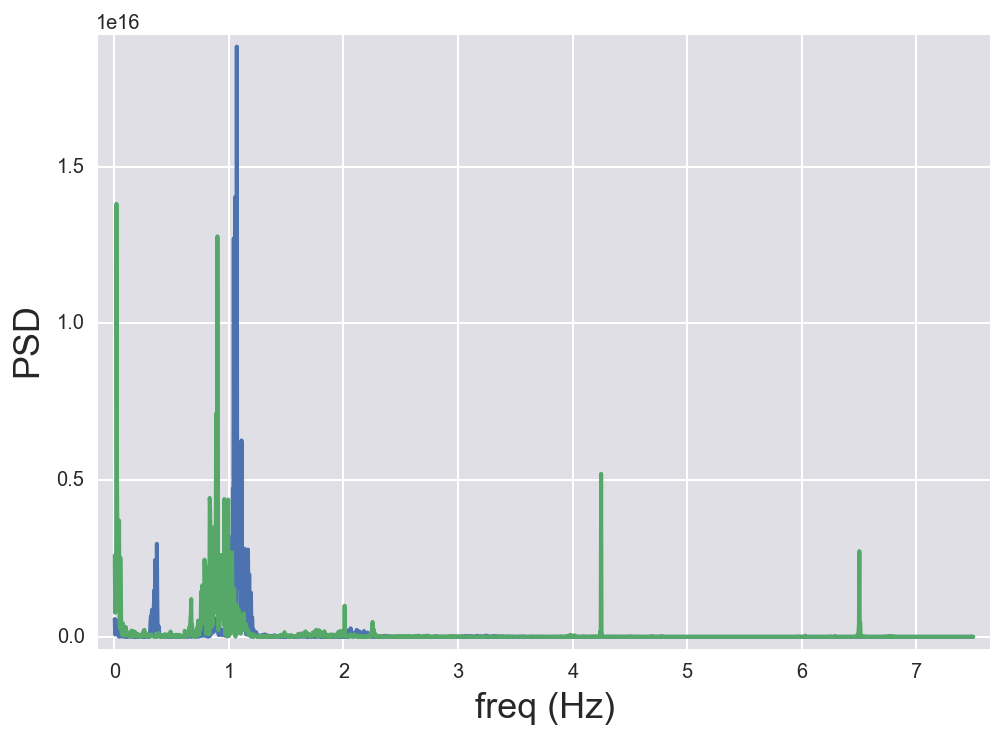

In [96]:
# Determine frequencies
f = np.fft.fftfreq(len(t)) * fps

# Compute power spectral density
psd = np.abs(np.fft.fft(total_int))**2 / len(t)

# Determine frequencies
f_night = np.fft.fftfreq(len(t_night)) * fps

# Compute power spectral density
psd_night = np.abs(np.fft.fft(total_int_night))**2 / len(t_night)



# Make plot
plt.plot(f[f>0], psd[f>0])
plt.plot(f_night[f_night>0], psd_night[f_night>0])
plt.xlabel('freq (Hz)')
plt.ylabel('PSD')
plt.margins(0.02)


In [74]:
def local_min(x, y):
    """
    Fit three points to quadratic and return location of maximum or minimum.
    """
    a, b, c = np.polyfit(x, y, 2)
    x_max = -b / 2 / a
    return x_max, a*x_max**2 + b*x_max + c

mean_total_int = np.mean(total_int)
total_int_normed = total_int - mean_total_int


# Find up and down crossing indices
up_crossing_inds = np.where(
    np.logical_and(total_int_normed[:-1] < 0, total_int_normed[1:] >= 0))[0]
down_crossing_inds = np.where(
    np.logical_and(total_int_normed[:-1] > 0, total_int_normed[1:] <= 0))[0] + 1

# Make sure upcrossing are first
if down_crossing_inds[0] < up_crossing_inds[0]:
    down_crossing_inds = down_crossing_inds[1:]
    
# Make sure downcrossing last
if up_crossing_inds[-1] > down_crossing_inds[-1]:
    up_crossing_inds = up_crossing_inds[:-1]
    
# Find maxima
t_peaks = np.empty(len(up_crossing_inds))
peaks = np.empty_like(t_peaks)
for i, uc in enumerate(up_crossing_inds):
    ind = uc + np.argmax(total_int[uc:down_crossing_inds[i]+1])
    t_peaks[i], peaks[i] = local_min(t[ind-1:ind+2], total_int[ind-1:ind+2])

In [76]:
#same for nighttime

mean_total_int_night = np.mean(total_int_night)
total_int_normed_night = total_int_night - mean_total_int_night


# Find up and down crossing indices
up_crossing_inds_night = np.where(
    np.logical_and(total_int_normed_night[:-1] < 0, total_int_normed_night[1:] >= 0))[0]
down_crossing_inds_night = np.where(
    np.logical_and(total_int_normed_night[:-1] > 0, total_int_normed_night[1:] <= 0))[0] + 1

# Make sure upcrossing are first
if down_crossing_inds_night[0] < up_crossing_inds_night[0]:
    down_crossing_inds_night = down_crossing_inds_night[1:]
    
# Make sure downcrossing last
if up_crossing_inds_night[-1] > down_crossing_inds_night[-1]:
    up_crossing_inds_night = up_crossing_inds_night[:-1]
    
# Find maxima
t_peaks_night = np.empty(len(up_crossing_inds_night))
peaks_night = np.empty_like(t_peaks_night)
for i, uc in enumerate(up_crossing_inds_night):
    ind = uc + np.argmax(total_int_night[uc:down_crossing_inds_night[i]+1])
    t_peaks_night[i], peaks_night[i] = local_min(t_night[ind-1:ind+2], total_int_night[ind-1:ind+2])

In [77]:
# Set up the figure (this is like a canvas you will paint on)
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'time (s)'
p.yaxis.axis_label = 'normalized intensity'

# Specify the glyphs
p.line(t, total_int, color='dodgerblue')
p.circle(t_peaks, peaks, size=5, color='tomato')
p.line(t_night, total_int_night, color='chocolate')
p.circle(t_peaks_night, peaks_night, size=5, color='lime')


bokeh.io.show(p)

# Day vs night intensity plot
The jellyfish here clearly displays pulsing behavior in both the day and the night, but at night, we can see several periods where the jellyfish "rests".  These periods are characterized by low total intensity (the jellyfish is contracted) and the loss of the ~1 hertz contractions.  It appears that these rest periods maintain some kind of low amplitude, high frequency insensity oscillations, but this may just be noise.

In [78]:
# Intercontractions times
t_int = np.diff(t_peaks)
t_int_night = np.diff(t_peaks_night)

# Plot them!
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'Contraction number'
p.yaxis.axis_label = 'Intercontraction time (s)'

# Specify the glyphs
p.line(t_peaks, t_int, color='dodgerblue')
p.line(t_peaks_night, t_int_night, color='lime')
bokeh.io.show(p)


ERROR://anaconda/lib/python3.4/site-packages/bokeh/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 116ce9a0-8a9e-4004-9a36-8ca22327f405
ERROR://anaconda/lib/python3.4/site-packages/bokeh/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 344aa1a5-e0c8-443f-bd0b-95fcff69a584


These "rest" periods are even more obvious when looking at intercontraction times.  The script we used above to identify oscillations does not reconize any of the motion that occurs in these "rest" periods as actual contractions, and thus we see that these "rest" periods last at least 10 seconds


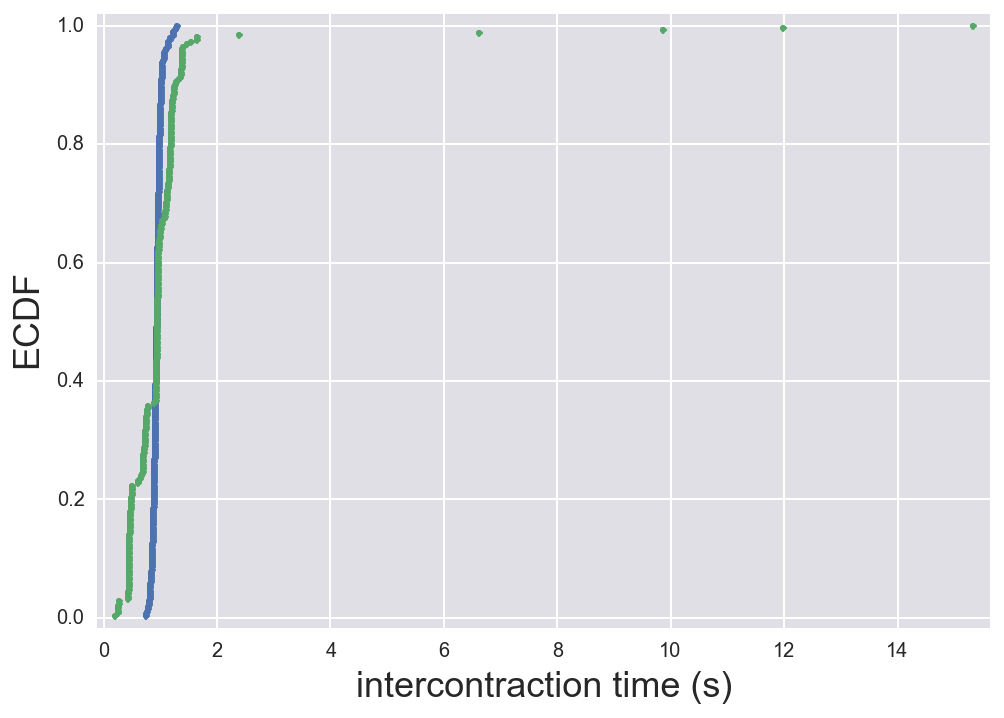

In [97]:
# Make x and y values for ECDF
x_day = np.sort(t_int)
y_day = np.arange(1, len(x_day)+1) / len(x_day)
plt.plot(x_day, y_day, '.')

x_night = np.sort(t_int_night)
y_night = np.arange(1, len(x_night)+1) / len(x_night)
plt.plot(x_night, y_night, '.')

plt.xlabel('intercontraction time (s)')
plt.ylabel('ECDF')
plt.margins(0.02)

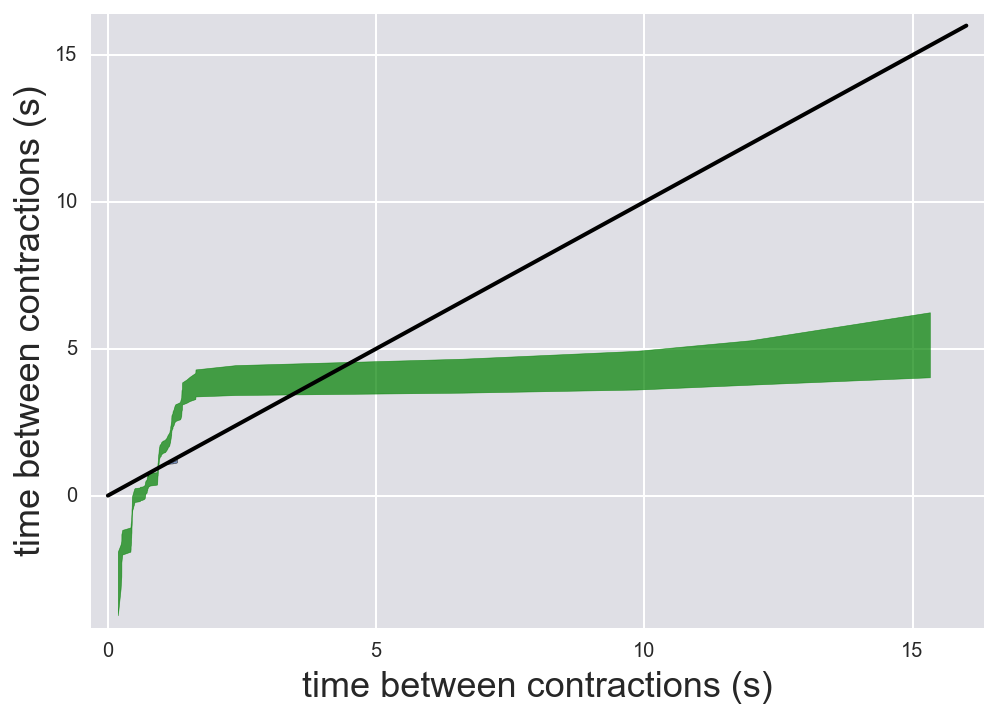

In [101]:
# Compute mean and standard deviation based on middle 50th percentile
mu = x_day.mean()
sigma = x_day.std()

# Make draws
theor_x = np.array(
    [np.sort(st.norm.rvs(mu, sigma, size=len(x_day))) for _ in range(1000)])

# Upper and lower bounds
low_theor, up_theor = np.percentile(theor_x, (2.5, 97.5), axis=0)




# Compute mean and standard deviation based on middle 50th percentile
mu_night = x_night.mean()
sigma_night = x_night.std()

# Make draws
theor_x_night = np.array(
    [np.sort(st.norm.rvs(mu_night, sigma_night, size=len(x_night))) for _ in range(1000)])

# Upper and lower bounds
low_theor_night, up_theor_night = np.percentile(theor_x_night, (2.5, 97.5), axis=0)



# Plot Q-Q plots with 95% conf.
plt.fill_between(x_day, up_theor, low_theor, alpha=0.7)


# Plot 45 degree line
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, x_lim, 'k-')

# Tidy up
plt.margins(0.02)

plt.xlabel('time between contractions (s)')
plt.ylabel('time between contractions (s)')

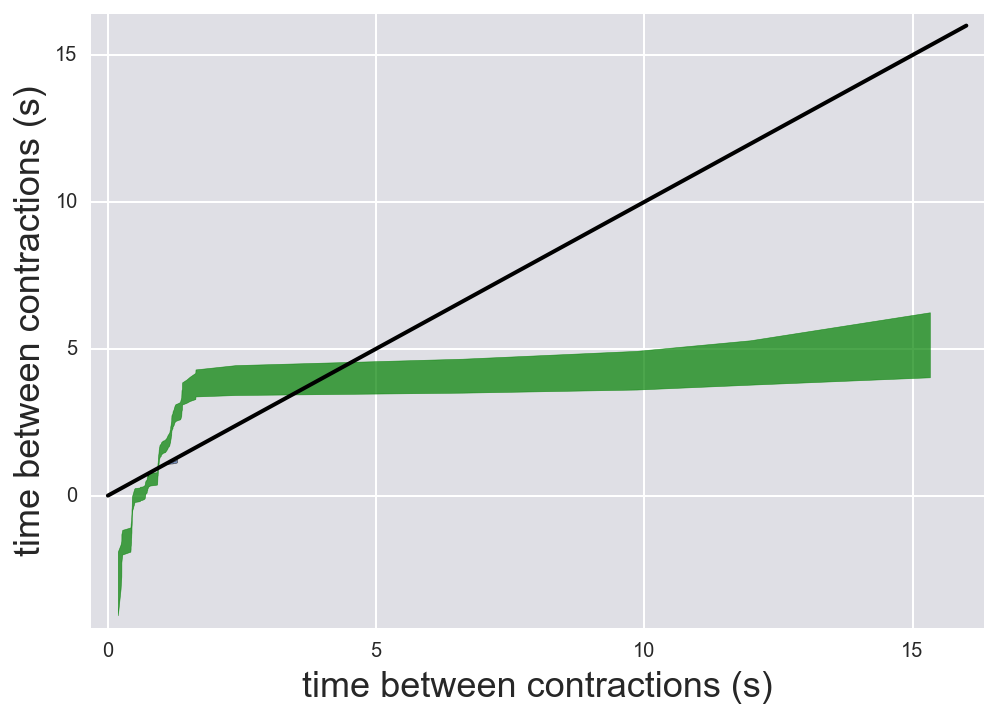

In [103]:
# Day
plt.fill_between(x_day, up_theor, low_theor, alpha=0.7)

# Night
plt.fill_between(x_night, up_theor_night, low_theor_night, alpha=0.7, color = 'green')

# Plot 45 degree line
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, x_lim, 'k-')

# Tidy up
plt.margins(0.02)
plt.xlabel('time between contractions (s)')
plt.ylabel('time between contractions (s)')

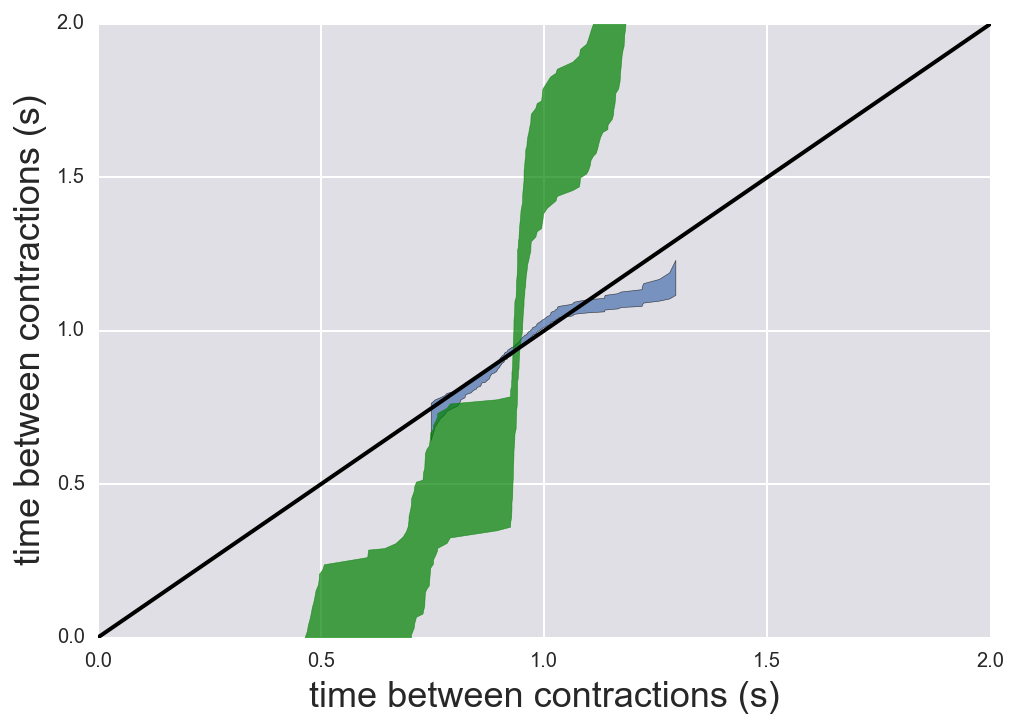

In [104]:
# We can't even see the qq plot for the day.  Zoom in

# Day
plt.fill_between(x_day, up_theor, low_theor, alpha=0.7)

# Night
plt.fill_between(x_night, up_theor_night, low_theor_night, alpha=0.7, color = 'green')

# Plot 45 degree line
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, x_lim, 'k-')

# Tidy up
plt.margins(0.02)
plt.axis ([0,2,0,2])
plt.xlabel('time between contractions (s)')
plt.ylabel('time between contractions (s)')

As we saw in the tutorial, during the day, the non-Gaussuanity of the plot is clear at long times between contractions, which suggests occasional pauses.
The night QQ plot shows high deviation from Gaussianity, with increasing non-Gaussianity for longer times between contractions.  This suggests that the propensity for pausing is much greater at night, which would suggest that the jellyfish rests more at night than it does during the day.

This analysis was done on only one jellyfish, and we need to confirm that this "resting" behavior is not just some fluke.  There are 7 other jellyfish that are in our picture, but analyzing all of them would take a long time.  Let's try one more, and see what it looks like:

In [106]:
# Daytime
data_dir = 'Cassiopea_Pulsation/day'

# Glob string for images
im_glob = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob)

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)

fps = 15
t_night = np.arange(0, len(ic_night)) / fps


# New set of verts for a new Jellyfish
verts = [(190, 220), # upper left
         (340, 240), # Upper right
         (340, 400), # Lower right
         (190, 390)] # Lower left

roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic[0].shape)

# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(ic[0])])

# Max out blue channel
im[roi,2] = skimage.dtype_limits(im)[1]

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=squish_rgb)

fps = 15
t = np.arange(0, len(ic)) / fps

roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic[0].shape)

# Get cropped image and ROI within it
im = ic[0][roi_bbox]
im_cropped_roi = roi_box

# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(im)])

# Load image collection
ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Set up NumPy array to store total pixel intensity
total_int = np.empty(len(t))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int[i] = ic[i][roi_box].sum()

//anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


In [107]:
# Nighttime
data_dir = 'Cassiopea_Pulsation/night'

# Glob string for images
im_glob_night = os.path.join(data_dir, '*.TIF')

# Get list of files in directory
im_list = glob.glob(im_glob_night)

In [108]:
ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=squish_rgb)

fps = 15
t_night = np.arange(0, len(ic_night)) / fps

# New set of verts for a new Jellyfish
verts = [(190, 220), # upper left
         (340, 240), # Upper right
         (340, 400), # Lower right
         (190, 390)] # Lower left

roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, *ic_night[0].shape)

# Get cropped image and ROI within it
im = ic_night[0][roi_bbox]
im_cropped_roi = roi_box

# Make grayscale image that is now RGB
im = np.dstack(3*[skimage.img_as_float(im)])

# Load image collection
ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox)

# Set up NumPy array to store total pixel intensity
total_int_night = np.empty(len(t_night))

# Look through and compute total intensity in the ROI
for i, im in enumerate(ic):
    total_int_night[i] = ic_night[i][roi_box].sum()

//anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


In [109]:
mean_total_int = np.mean(total_int)
total_int_normed = total_int - mean_total_int


# Find up and down crossing indices
up_crossing_inds = np.where(
    np.logical_and(total_int_normed[:-1] < 0, total_int_normed[1:] >= 0))[0]
down_crossing_inds = np.where(
    np.logical_and(total_int_normed[:-1] > 0, total_int_normed[1:] <= 0))[0] + 1

# Make sure upcrossing are first
if down_crossing_inds[0] < up_crossing_inds[0]:
    down_crossing_inds = down_crossing_inds[1:]
    
# Make sure downcrossing last
if up_crossing_inds[-1] > down_crossing_inds[-1]:
    up_crossing_inds = up_crossing_inds[:-1]
    
# Find maxima
t_peaks = np.empty(len(up_crossing_inds))
peaks = np.empty_like(t_peaks)
for i, uc in enumerate(up_crossing_inds):
    ind = uc + np.argmax(total_int[uc:down_crossing_inds[i]+1])
    t_peaks[i], peaks[i] = local_min(t[ind-1:ind+2], total_int[ind-1:ind+2])

    
#same for nighttime

mean_total_int_night = np.mean(total_int_night)
total_int_normed_night = total_int_night - mean_total_int_night


# Find up and down crossing indices
up_crossing_inds_night = np.where(
    np.logical_and(total_int_normed_night[:-1] < 0, total_int_normed_night[1:] >= 0))[0]
down_crossing_inds_night = np.where(
    np.logical_and(total_int_normed_night[:-1] > 0, total_int_normed_night[1:] <= 0))[0] + 1

# Make sure upcrossing are first
if down_crossing_inds_night[0] < up_crossing_inds_night[0]:
    down_crossing_inds_night = down_crossing_inds_night[1:]
    
# Make sure downcrossing last
if up_crossing_inds_night[-1] > down_crossing_inds_night[-1]:
    up_crossing_inds_night = up_crossing_inds_night[:-1]
    
# Find maxima
t_peaks_night = np.empty(len(up_crossing_inds_night))
peaks_night = np.empty_like(t_peaks_night)
for i, uc in enumerate(up_crossing_inds_night):
    ind = uc + np.argmax(total_int_night[uc:down_crossing_inds_night[i]+1])
    t_peaks_night[i], peaks_night[i] = local_min(t_night[ind-1:ind+2], total_int_night[ind-1:ind+2])
    
# Set up the figure (this is like a canvas you will paint on)
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'time (s)'
p.yaxis.axis_label = 'normalized intensity'

# Specify the glyphs
p.line(t, total_int, color='dodgerblue')
p.circle(t_peaks, peaks, size=5, color='tomato')
p.line(t_night, total_int_night, color='chocolate')
p.circle(t_peaks_night, peaks_night, size=5, color='lime')


bokeh.io.show(p)

# Day vs night intensity plot for Jellyfish 2
The  second jellyfish dsiplays similar behavior to the first; the major difference being that the second jellyfish appears to have rest bouts during the day, as well as at night.  However, the second jellyfish still appears to rest more at night than it does during the day.

In [110]:
# Intercontractions times
t_int = np.diff(t_peaks)
t_int_night = np.diff(t_peaks_night)

# Plot them!
p = bokeh.plotting.figure(background_fill='#DFDFE5', plot_width=650, 
                          plot_height=450)
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'Contraction number'
p.yaxis.axis_label = 'Intercontraction time (s)'

# Specify the glyphs
p.line(t_peaks, t_int, color='dodgerblue')
p.line(t_peaks_night, t_int_night, color='lime')
bokeh.io.show(p)

ERROR://anaconda/lib/python3.4/site-packages/bokeh/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 035022a6-1035-40ff-aa2b-fc490cfec955
ERROR://anaconda/lib/python3.4/site-packages/bokeh/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource, ViewModel:ColumnDataSource, ref _id: 48dff143-be27-44a6-a76a-b60887bce62c


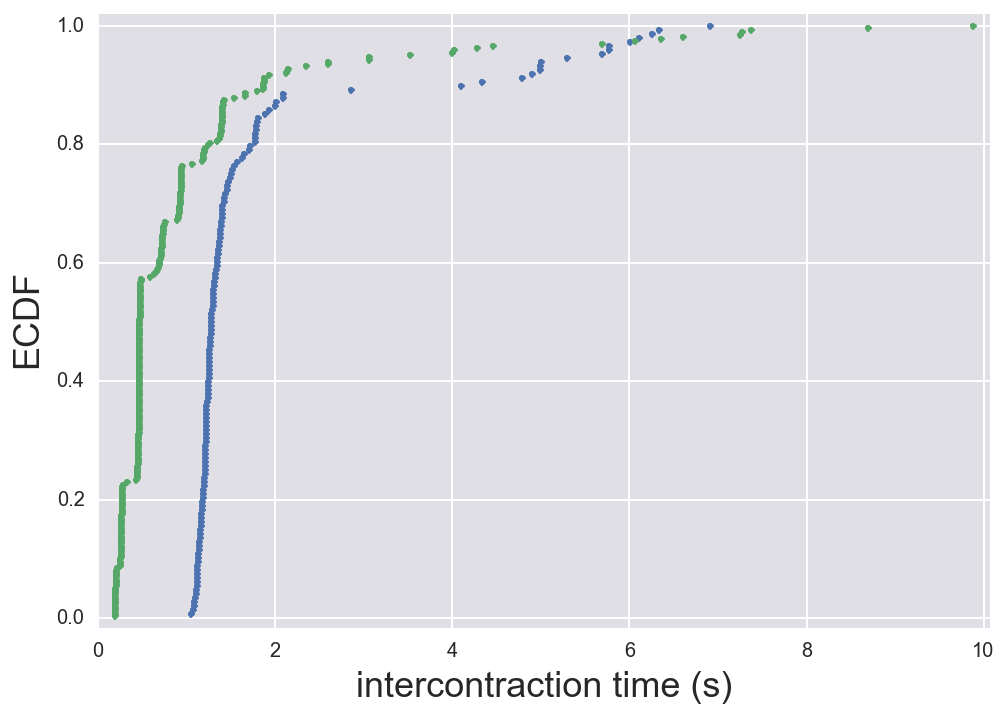

In [111]:
# Make x and y values for ECDF
x_day = np.sort(t_int)
y_day = np.arange(1, len(x_day)+1) / len(x_day)
plt.plot(x_day, y_day, '.')

x_night = np.sort(t_int_night)
y_night = np.arange(1, len(x_night)+1) / len(x_night)
plt.plot(x_night, y_night, '.')

plt.xlabel('intercontraction time (s)')
plt.ylabel('ECDF')
plt.margins(0.02)

Similar effects are visible in the contraction numbers and intercontraction times:  the second jellyfish rests during the day, but rests more during the night.

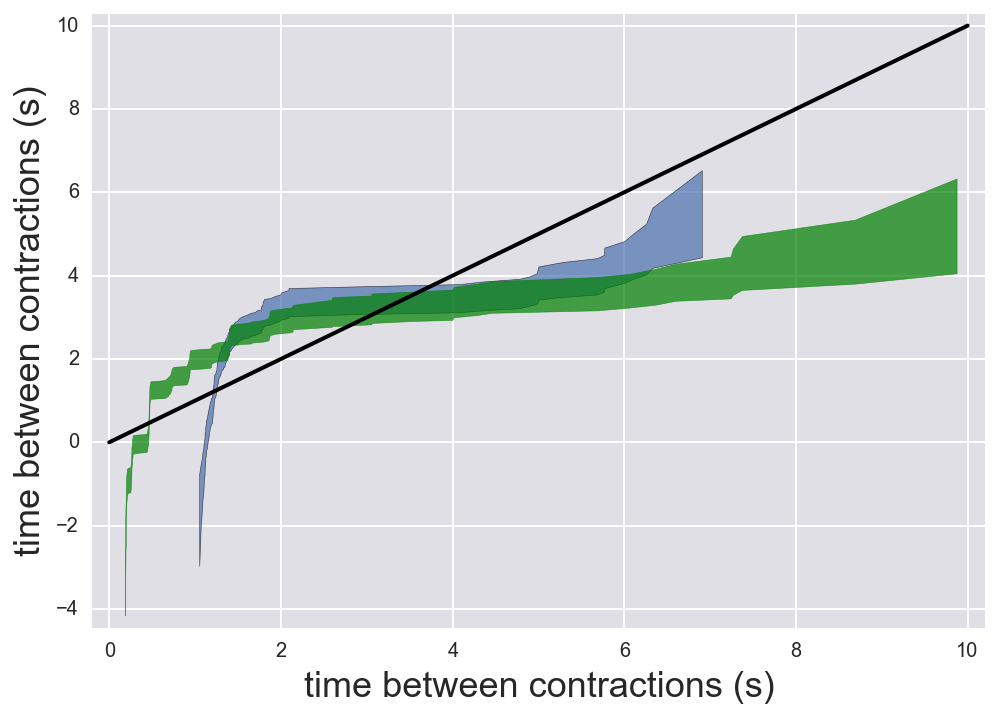

In [113]:
# Compute mean and standard deviation based on middle 50th percentile
mu = x_day.mean()
sigma = x_day.std()

# Make draws
theor_x = np.array(
    [np.sort(st.norm.rvs(mu, sigma, size=len(x_day))) for _ in range(1000)])

# Upper and lower bounds
low_theor, up_theor = np.percentile(theor_x, (2.5, 97.5), axis=0)




# Compute mean and standard deviation based on middle 50th percentile
mu_night = x_night.mean()
sigma_night = x_night.std()

# Make draws
theor_x_night = np.array(
    [np.sort(st.norm.rvs(mu_night, sigma_night, size=len(x_night))) for _ in range(1000)])

# Upper and lower bounds
low_theor_night, up_theor_night = np.percentile(theor_x_night, (2.5, 97.5), axis=0)



# Plot Q-Q plots with 95% conf.
plt.fill_between(x_day, up_theor, low_theor, alpha=0.7)
# Night
plt.fill_between(x_night, up_theor_night, low_theor_night, alpha=0.7, color = 'green')

# Plot 45 degree line
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, x_lim, 'k-')

# Tidy up
plt.margins(0.02)

plt.xlabel('time between contractions (s)')
plt.ylabel('time between contractions (s)')

# Conclusions

The first jellyfish displayed a more straight-forward resting behavior at night, mostly because we did not see any evidence of resting during the day, and we saw evidence of resting during the night.  The second jellyfish also displays a resting behavior at night, but because the jellyfish also appears to rest during the day, the difference between day and night is less pronounced. 
There are six more jellyfish that we could analyze, but time constraints make it less than practical to repeat these analyses because the command
for i, im in enumerate(ic):

    total_int_night[i] = ic_night[i][roi_box].sum()
    
takes more than two hours to execute on my computer.

Thus, drawing conclusions from the two jellyfish analyzed here, it does appear that these jellyfish display one of the criteria for sleep.

According to the definition of sleep presented in class, to show that jellyfish sleep we would also need to show that they display some kind of stress behavior when deprived of sleep, and  that they have a "waking" behavior, where it takes a greater stimulus to elicit a response when the jellyfish are in their resting state than when they appear to not be in a resting state.